In [1]:
from pathlib import Path
import pandas as pd
from io import BytesIO
import sys
import PIL.Image as PILImage
import requests
import random
from termcolor import colored


import numpy as np
import matplotlib.pyplot as plt
import objaverse

sys.path.append(str(Path("..").resolve()))
from src import *

# Generate the dataset (Objaverse)
##### ℹ️ This notebook requires `dataset/objaverse/2-annotations_filtered_by_thumbnails.parquet` and `dataset/objaverse/statistics.parquet`, which is generated by `compute_statistics.py`
This notebook generate the dataset as triplets of _rendering_, _UV map_ and _diffuse texture_.
##### ⚠️ This notebook is just a preview of the actual script (see [generate_dataset.py](generate_dataset.py)). The generation of the entire dataset is expensive and thus requires a computation node.

In [2]:
dataset = ObjaverseDataset3D()

Select only the objects with 1 Mesh, 1 UV map and 1 Diffuse texture

In [3]:
uids = dataset.statistics[dataset.statistics["valid"]].index
annotations = pd.read_parquet("../dataset/objaverse/2-annotations_filtered_by_thumbnails.parquet", engine="pyarrow")


Choosing the mean standard deviation threshold to consider the texture "non-homogeneous"

Downloaded 1 / 299 objects
Downloaded 2 / 299 objects
Downloaded 3 / 299 objects
Downloaded 4 / 299 objects
Downloaded 5 / 299 objects
Downloaded 6 / 299 objects
Downloaded 7 / 299 objects
Downloaded 8 / 299 objects
Downloaded 9 / 299 objects
Downloaded 10 / 299 objects
Downloaded 11 / 299 objects
Downloaded 12 / 299 objects
Downloaded 13 / 299 objects
Downloaded 14 / 299 objects
Downloaded 15 / 299 objects
Downloaded 16 / 299 objects
Downloaded 17 / 299 objects
Downloaded 18 / 299 objects
Downloaded 19 / 299 objects
Downloaded 20 / 299 objects
Downloaded 21 / 299 objects
Downloaded 22 / 299 objects
Downloaded 23 / 299 objects
Downloaded 24 / 299 objects
Downloaded 25 / 299 objects
Downloaded 26 / 299 objects
Downloaded 27 / 299 objects
Downloaded 28 / 299 objects
Downloaded 29 / 299 objects
Downloaded 30 / 299 objects
Downloaded 31 / 299 objects
Downloaded 32 / 299 objects
Downloaded 33 / 299 objects
Downloaded 34 / 299 objects
Downloaded 35 / 299 objects
Downloaded 36 / 299 objects
D

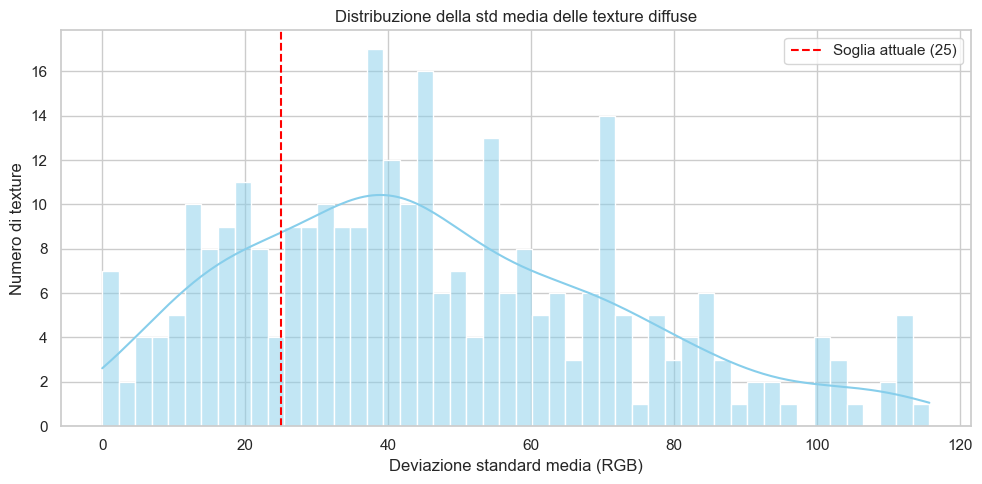

In [ ]:
def compute_mean_std(texture_img: PILImage.Image) -> float:
    arr = np.asarray(texture_img.convert("RGB"), dtype=np.float32)
    std_rgb = arr.std(axis=(0, 1))
    mean_std = float(std_rgb.mean())
    return mean_std

uids_sample = random.sample(list(uids), 300)  

paths = objaverse.load_objects(uids_sample, download_processes=1)

mean_std_values = []

for uid in uids_sample:
    try:
        obj = ObjaverseObject3D(uid, paths[uid])
        texture = obj.textures[0].convert("RGB")
        mean_std = compute_mean_std(texture)
        mean_std_values.append(mean_std)
    except Exception as e:
        print(f"❌ UID {uid} saltato: {e}")
        continue

print(f"✅ Calcolata la std media per {len(mean_std_values)} texture.\n")

sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(mean_std_values, kde=True, bins=50, color="skyblue")
plt.axvline(x=25, color="red", linestyle="--", label="Soglia attuale (25)")
plt.xlabel("Deviazione standard media (RGB)")
plt.ylabel("Numero di texture")
plt.title("Distribuzione della std media delle texture diffuse")
plt.legend()
plt.tight_layout()
plt.show()


🔽 Inizio download/caricamento tramite objaverse…
Downloaded 1 / 5 objects
Downloaded 2 / 5 objects
Downloaded 3 / 5 objects
Downloaded 4 / 5 objects
Downloaded 5 / 5 objects
✔️  Tutti gli asset sono pronti.


👉 Elaborazione UID = 66c5bf12847c42089dc91ce74c0c4637
19:21:13 | INFO: Data are loaded, start creating Blender stuff


[05/23/25 19:21:13] INFO     Data are loaded, start creating Blender stuff

19:21:13 | INFO: Blender create Mesh node Object_0


                    INFO     Blender create Mesh node Object_0

19:21:13 | INFO: glTF import finished in 0.15s


                    INFO     glTF import finished in 0.15s

Texture: std = 23.00, omogenea = True
Render : std = 42.91, omogenea = False


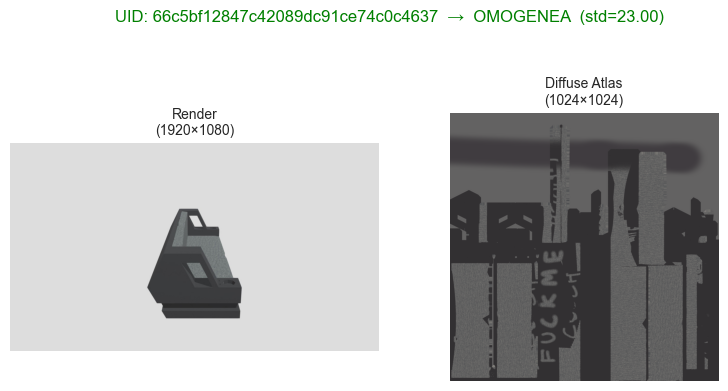


👉 Elaborazione UID = 1d75cc13f83f4bc1b7c6a8cb01294f4a
Texture: std = 15.40, omogenea = True
Render : std = 36.78, omogenea = False


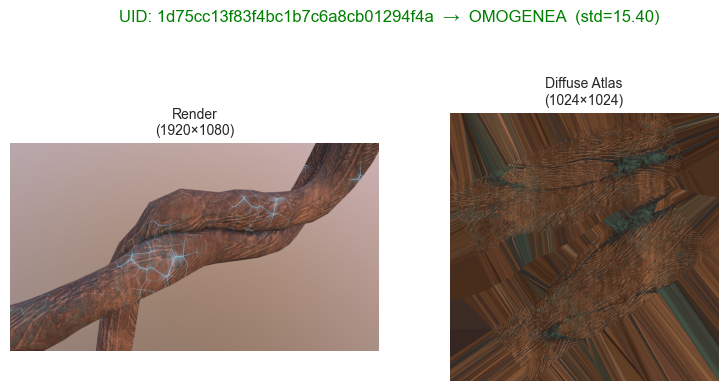


👉 Elaborazione UID = 05ed4726bd104ac5971afebb5bf8527b
Texture: std = 31.64, omogenea = False
Render : std = 18.68, omogenea = True


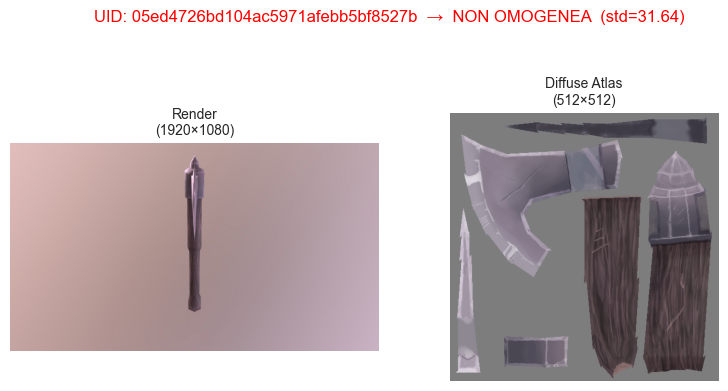


👉 Elaborazione UID = d4c9180a46cf401fa24fa3afe9237a43
Texture: std = 44.71, omogenea = False
Render : std = 33.60, omogenea = False


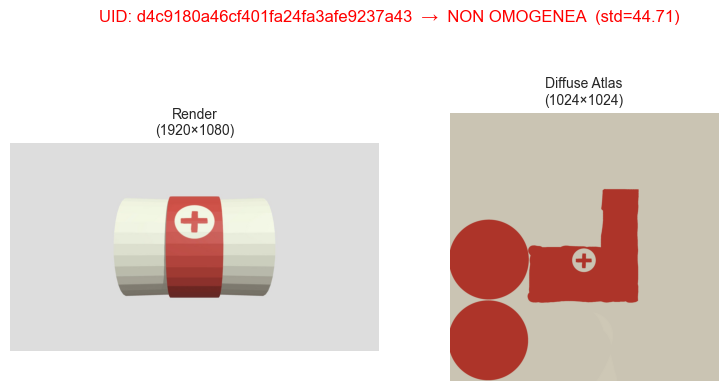


👉 Elaborazione UID = 6d1fab58875e434194d131075a12b7f7
Texture: std = 40.79, omogenea = False
Render : std = 17.32, omogenea = True


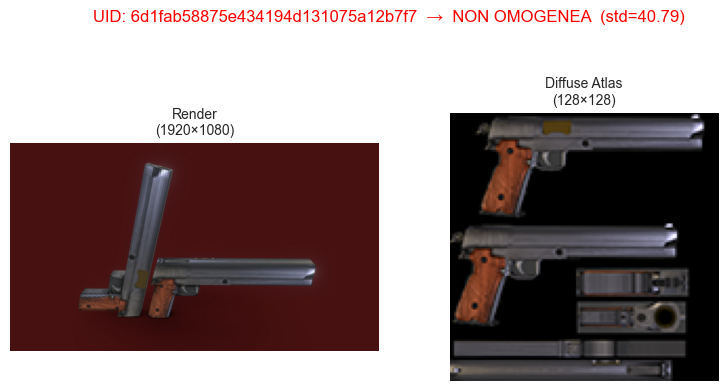


🎉 Elaborazione completata per tutti gli UID campionati.


In [ ]:
MIN_STD_THRESHOLD = 25.0   # soglia di deviazione standard media per considerare la texture "non omogenea"
N_SAMPLES = 5     # quanti oggetti voglio campionare
random.seed(23)

uids_list = list(uids)
uids_min = random.sample(uids_list, min(N_SAMPLES, len(uids_list)))

print("\n🔽 Inizio download/caricamento tramite objaverse…")
paths = objaverse.load_objects(uids_min, download_processes=1)

for uid in uids_min:
    if uid not in paths:
        raise RuntimeError(f"UID {uid} non presente in `paths` restituito da objaverse.load_objects.")
print("✔️  Tutti gli asset sono pronti.\n")

# Funzione per valutare omogeneità texture
def is_texture_homogeneous(texture_img: PILImage.Image, std_threshold: float = MIN_STD_THRESHOLD) -> (bool, float):
    """
    Calcola la deviazione standard media sui tre canali RGB della texture_img.
    Restituisce (omogenea_flag, std_media).
    Se std_media < std_threshold, la texture è considerata omogenea.
    """
    arr = np.asarray(texture_img.convert("RGB"), dtype=np.float32)  

    std_rgb = arr.std(axis=(0, 1))

    mean_std = float(std_rgb.mean())

    is_homog = (mean_std < std_threshold)
    return is_homog, mean_std

def plot_render_and_diffuse(render_img: PILImage.Image, diffuse_img: PILImage.Image, 
                            uid: str, omogenea: bool, std_val: float):
    """
    Mostra due immagini affiancate:
      - [0] render frontale (PIL.Image)
      - [1] diffuse texture (PIL.Image)
    Aggiunge titolo complessivo "UID: ..." e un messaggio OMOGENEA / NON OMOGENEA.
    """
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Render
    axes[0].imshow(render_img)
    axes[0].axis("off")
    axes[0].set_title(f"Render\n({render_img.width}×{render_img.height})", fontsize=10)
    
    # Diffuse
    axes[1].imshow(diffuse_img)
    axes[1].axis("off")
    axes[1].set_title(f"Diffuse Atlas\n({diffuse_img.width}×{diffuse_img.height})", fontsize=10)
    
    # Titolo generale con stato
    stato = "OMOGENEA" if omogenea else "NON OMOGENEA"
    color = "green" if omogenea else "red"
    plt.suptitle(f"UID: {uid}  →  {stato}  (std={std_val:.2f})", color=color, fontsize=12)
    
    plt.tight_layout(rect=[0, 0.0, 1, 0.92])
    plt.show()

for uid in uids_min:
    print(f"\n👉 Elaborazione UID = {uid}")
    local_path = paths[uid]
    
    try:
        obj = ObjaverseObject3D(uid, local_path)
    except Exception as e:
        print(colored(f"Errore: impossibile inizializzare ObjaverseObject3D per {uid}: {e}", "red"))
        continue
    
    try:
        thumbnail_url = annotations.loc[uid]["thumbnail"]
        thumb_bytes   = requests.get(thumbnail_url).content
        render_img    = PILImage.open(BytesIO(thumb_bytes)).convert("RGB")
    except Exception as e:
        print(colored(f"Errore: non è stato possibile scaricare/convertire la thumbnail per {uid}: {e}", "red"))
        continue
    
    try:
        diffuse_img = obj.textures[0].convert("RGB")
    except Exception as e:
        print(colored(f"Errore: non ho trovato obj.textures[0] per {uid}: {e}", "red"))
        continue
    
    omogenea, std_val = is_texture_homogeneous(diffuse_img, std_threshold=MIN_STD_THRESHOLD)
    omog_render,  std_render  = is_texture_homogeneous(render_img, std_threshold=MIN_STD_THRESHOLD)   #qui applico la funzione sul render, è migliore?
    
    print(f"Texture: std = {std_val:.2f}, omogenea = {omogenea}")
    print(f"Render : std = {std_render:.2f}, omogenea = {omog_render}")
    
    plot_render_and_diffuse(render_img, diffuse_img, uid, omogenea, std_val)

print("\n🎉 Elaborazione completata per tutti gli UID campionati.")

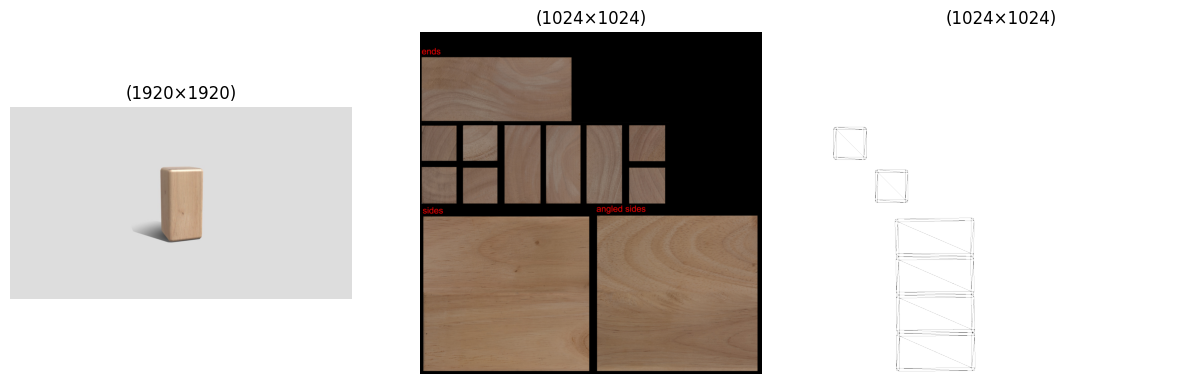

UV density = 0.99% --> TOO LOW


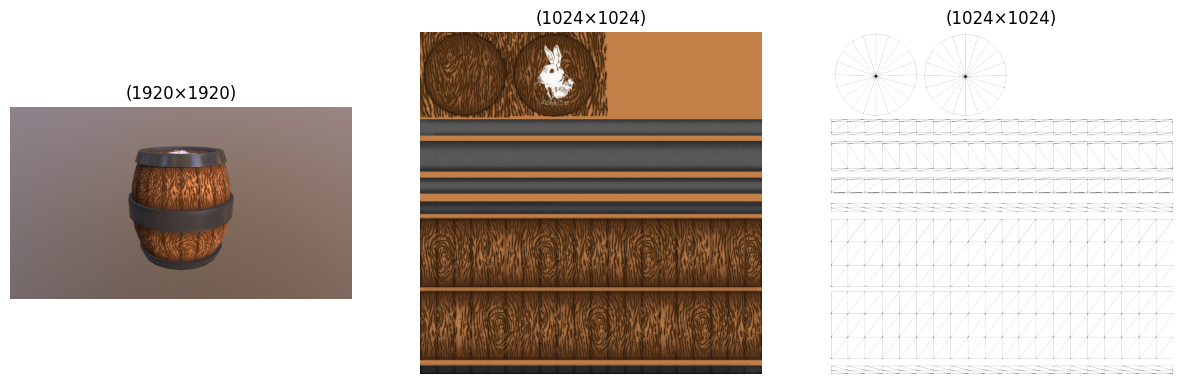

UV density = 6.26% --> OK


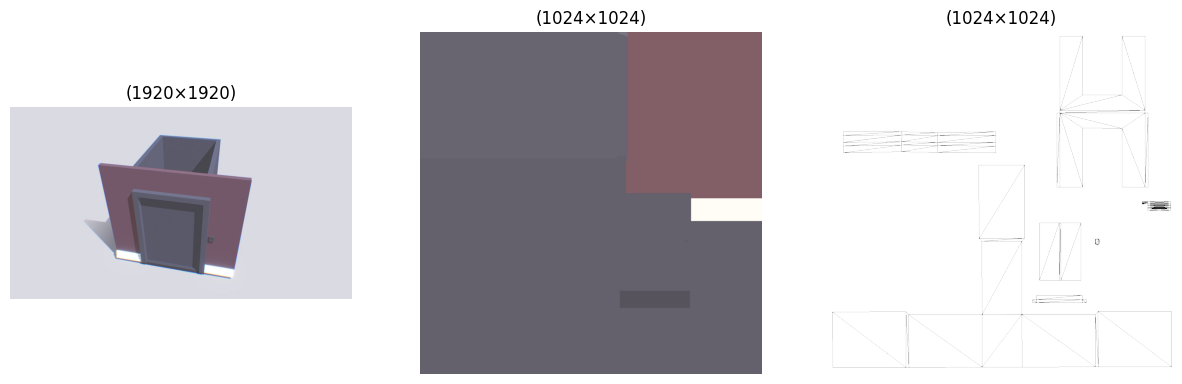

UV density = 1.87% --> OK


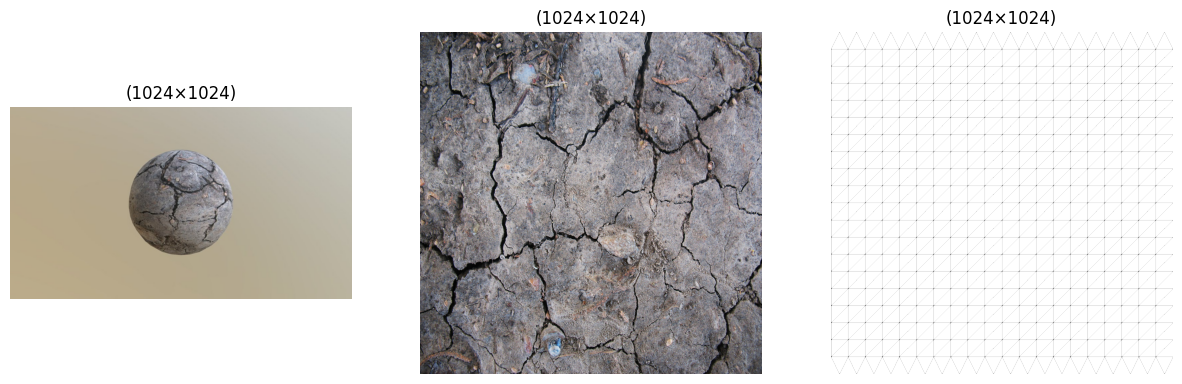

UV density = 5.70% --> OK


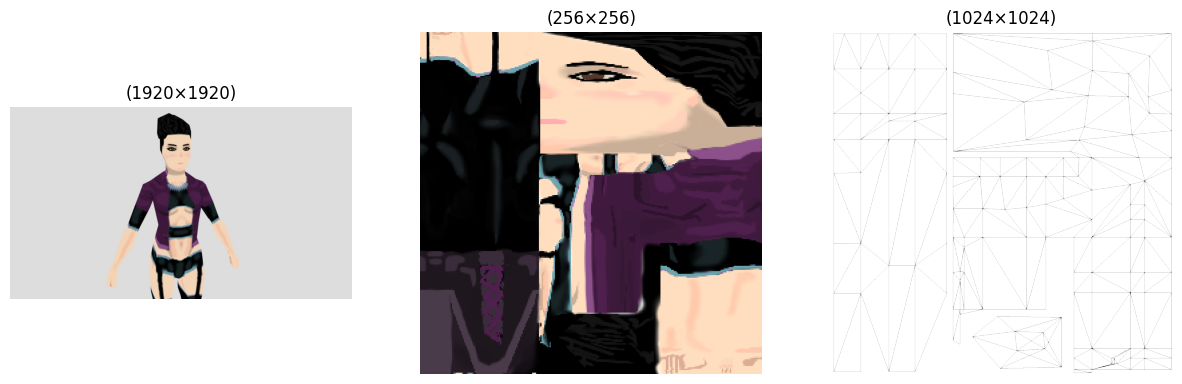

UV density = 3.78% --> OK


In [ ]:
MIN_UV_DENSITY = 0.01
SAMPLES = 5

for uid in uids[random.sample(range(len(uids)), SAMPLES)]:
    obj = dataset[uid]
    rendering = obj.rendering
    diffuse = obj.textures[0]
    uv_map = obj.draw_uv()

    imshow([rendering, diffuse, uv_map], cols=3, size=5)
    uv_density = compute_image_density(uv_map)
    print(
        colored(
            text=f"[{uid}] UV density = {uv_density:.2%} --> {'OK' if uv_density > MIN_UV_DENSITY else 'TOO LOW'}",
            color="green" if uv_density > MIN_UV_DENSITY else "red",
        )
    )